# Synthetic Data Generation

This example shows how to use Torch-EPG-X to generate synthetic data.

We will use torchio and sigpy to get realistic ground truth maps and
coil sensitivities. These can be installed as

``pip install torchio``
``pip install sigpy``


We will use realistic maps from the IXI dataset,
downloaded using ``torchio``:

In [1]:
import torchio as tio

ixi_dataset = tio.datasets.IXI(
    '/home/mcencini//ixi/',
    modalities=('PD','T1', 'T2'),
    download=False,
)

# get subject 0
sample_subject = ixi_dataset[0]

/home/mcencini/.conda/envs/mrsim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will now extract an example slice 
and compute M0 and T2 maps to be used
as simulation inputs.

In [2]:
import numpy as np

M0 = sample_subject.PD.numpy().astype(np.float32).squeeze()[:, :, 60].T
T2w = sample_subject.T2.numpy().astype(np.float32).squeeze()[:, :, 60].T

Compute T2 map:

In [3]:
sa = np.sin(np.deg2rad(8.0))
ta = np.tan(np.deg2rad(8.0))

T2 = -92.0 / np.log(T2w/M0)
T2 = np.nan_to_num(T2, neginf=0.0, posinf=0.0)
T2 = np.clip(T2, a_min=0.0, a_max=np.inf)

M0 = np.flip(M0)
T2 = np.flip(T2)

/tmp/ipykernel_28371/2973954694.py:4: RuntimeWarning: divide by zero encountered in divide
  T2 = -92.0 / np.log(T2w/M0)
/tmp/ipykernel_28371/2973954694.py:4: RuntimeWarning: invalid value encountered in divide
  T2 = -92.0 / np.log(T2w/M0)
/tmp/ipykernel_28371/2973954694.py:4: RuntimeWarning: divide by zero encountered in log
  T2 = -92.0 / np.log(T2w/M0)


Let's use epgtorchx fse simulator

In [4]:
import epgtorchx as epgx

def simulate(T2, flip, ESP, phases=None, device="cpu"):
    if phases is None:
        phases = -np.ones_like(flip) * 90.0
    
    # get ishape
    ishape = T2.shape   
    output = epgx.fse(flip, phases, ESP, 1000.0,  T2.flatten(), device=device)
    
    return abs(output.T.reshape(-1, *ishape))

Assume a constant refocusing train

(<matplotlib.image.AxesImage at 0x7f52a8cd9370>,
 (-0.5, 767.5, 255.5, -0.5),
 (-0.5, 767.5, 255.5, -0.5))

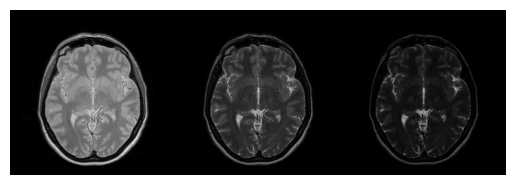

In [5]:
flip = 180.0 * np.ones(32, dtype=np.float32)
ESP = 5.0
device="cpu"

# simulate acquisition
echo_series = M0 * simulate(T2, flip, ESP, device=device)

# display
img = np.concatenate((echo_series[0], echo_series[16], echo_series[-1]), axis=1)

import matplotlib.pyplot as plt
plt.imshow(abs(img), cmap="gray"), plt.axis("image"), plt.axis("off")

Now, we want to add coil sensitivities. We will use sigpy:

In [6]:
import sigpy.mri as smri

smaps = smri.birdcage_maps((8, *echo_series.shape[1:]))

We can simulate effects of coil by simple multiplication:

In [7]:
echo_series = smaps[:, None, ...] * echo_series
print(echo_series.shape)

(8, 32, 256, 256)


Now, we want to simulate k-space encoding. We will use a simple Poisson Cartesian encoding
from Sigpy.

(<matplotlib.image.AxesImage at 0x7f528b549bb0>,
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 <matplotlib.colorbar.Colorbar at 0x7f5279300920>)

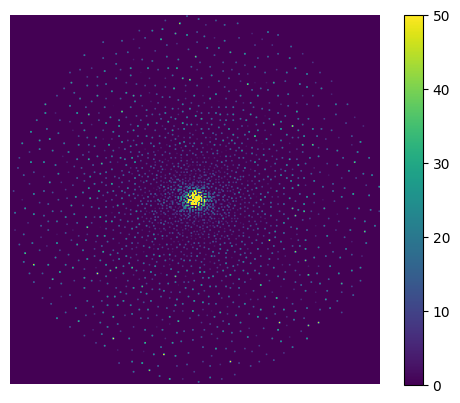

In [8]:
import sigpy as sp

mask = np.stack([smri.poisson(T2.shape, 32) for n in range(32)], axis=0)
ksp = mask * sp.fft(mask * echo_series, axes=range(-2, 0))

plt.imshow(abs(ksp[0, 0]), vmax=50), plt.axis("image"), plt.axis("off"), plt.colorbar()

Potentially, we could use Non-Cartesian sampling and include non-idealities
such as B0 accrual and T2* decay during readout using ``mri-nufft``.

Now, we can wrap it up:

In [10]:
def generate_synth_data(M0, T2, flip, ESP, phases=None, ncoils=8, device="cpu"):
    echo_series = M0 * simulate(T2, flip, ESP, device=device)
    smaps = smri.birdcage_maps((ncoils, *echo_series.shape[1:]))
    echo_series = smaps[:, None, ...] * echo_series
    mask = np.stack([smri.poisson(T2.shape, len(flip)) for n in range(len(flip))], axis=0)
    return mask * sp.fft(echo_series, axes=range(-2, 0))

Reconstruction shows the effect of undersampling:

(<matplotlib.image.AxesImage at 0x7f5279300e00>,
 (-0.5, 767.5, 255.5, -0.5),
 (-0.5, 767.5, 255.5, -0.5))

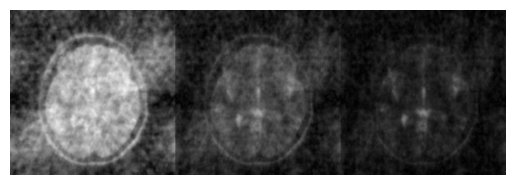

In [11]:
ksp = generate_synth_data(M0, T2, flip, ESP, device=device)
recon = sp.ifft(ksp, axes=range(-2, 0))
recon = (recon**2).sum(axis=0)**0.5
img = np.concatenate((recon[0], recon[16], recon[-1]), axis=1)
plt.imshow(abs(img), cmap="gray"), plt.axis("image"), plt.axis("off")

This can be combined with data augmentation in torchio to generate synthetic 
datasets, such as in Synth-MOLED





